In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = "OCR Interview Employee and Applicant Dataset.xlsx"
xls = pd.ExcelFile(file_path)

# Load both sheets into dataframes
employee_df = pd.read_excel(xls, sheet_name="Employee Data")
applicant_df = pd.read_excel(xls, sheet_name="Applicant Data")

# Identify columns that contain names
name_columns_employee = [col for col in employee_df.columns if "name" in col.lower()]
name_columns_applicant = [col for col in applicant_df.columns if "name" in col.lower()]

# Remove name columns by replacing them with 'REDACTED'
for col in name_columns_employee:
    employee_df[col] = "REDACTED"

for col in name_columns_applicant:
    applicant_df[col] = "REDACTED"

# Save the cleaned dataframes to CSV files
employee_df.to_csv("Redacted_Employee_Data.csv", index=False)
applicant_df.to_csv("Redacted_Applicant_Data.csv", index=False)

print("Cleaned data has been saved to 'Redacted_Employee_Data.csv' and 'Cleaned_Applicant_Data.csv'.")


Cleaned data has been saved to 'Redacted_Employee_Data.csv' and 'Cleaned_Applicant_Data.csv'.


In [20]:
# Get unique columns
employee_columns = set(employee_df.columns)
applicant_columns = set(applicant_df.columns)

unique_to_employee = employee_columns - applicant_columns
unique_to_applicant = applicant_columns - employee_columns

unique_to_employee, unique_to_applicant

# Find overlapping columns
common_columns = employee_columns.intersection(applicant_columns)

# Find unique columns in each dataset
unique_to_employee = employee_columns - applicant_columns
unique_to_applicant = applicant_columns - employee_columns

# Display results
print("Common Columns:", common_columns)
print("Unique to Employee Data:", unique_to_employee)
print("Unique to Applicant Data:", unique_to_applicant)


Common Columns: {'Disab Vet', 'Mil Status', 'Race/Ethnicity', 'Disabled', 'Sex', 'Position Number'}
Unique to Employee Data: {'Res Cntry', 'Position Type', 'EEO-6 Cat', 'Start Date', 'Position Category', 'Translate', 'Ctzn Ctry', 'Employee ID', 'Birthdate', 'Name', 'Annual Salary', 'Job Fmaily'}
Unique to Applicant Data: {'Applicant Status', 'Applicant ID', 'Internal/External Applicant'}


In [21]:
# Correct the typo in the employee dataset column name
employee_df.rename(columns={'Job Fmaily': 'Job Family'}, inplace=True)

# Create a mapping from Position Number to Job Family using the employee dataset
position_to_job_family = employee_df.set_index('Position Number')['Job Family'].to_dict()

# Map the Job Family onto the applicant dataset using Position Number
applicant_df['Job Family'] = applicant_df['Position Number'].map(position_to_job_family)

# Display the first few rows of the updated applicant dataset to verify changes
print(applicant_df.head())


   Position Number  Applicant ID        Applicant Status  \
0          10008.0      11190926     Rejected; Interview   
1          10008.0      15071183  Rejected; No Interview   
2          10008.0      31463813  Rejected; No Interview   
3          10008.0      37684974  Rejected; No Interview   
4          10008.0      44964139  Rejected; No Interview   

  Internal/External Applicant     Sex Disabled Disab Vet  \
0                    External    Male        N         N   
1                    External  Female      NaN       NaN   
2                    External  Female      NaN       NaN   
3                    External    Male      NaN       NaN   
4                    External    Male      NaN       NaN   

           Race/Ethnicity     Mil Status Job Family  
0                   White  Not a Veteran   Research  
1                   Asian  Not indicated   Research  
2  Black/African American  Not indicated   Research  
3                   White  Not indicated   Research  
4  Black

In [22]:
employee_df.to_csv("Redacted_Employee_Data.csv", index=False)
applicant_df.to_csv("Redacted_Applicant_Data.csv", index=False)

In [12]:
# Initialize a list to store significant differences
significant_differences = []
job_families = employee_df["Job Family"].dropna().unique()
demographic_columns = ["Sex", "Disabled", "Disab Vet", "Race/Ethnicity", "Mil Status"]

# Iterate over all job families and demographic columns
for job_family in job_families:
    for demographic in demographic_columns:
        # Filter employee and applicant data for the current job family
        employee_subset = employee_df[employee_df["Job Family"] == job_family]
        applicant_subset = applicant_df[applicant_df["Job Family"] == job_family]

        # Calculate percentage distributions
        employee_counts = employee_subset[demographic].value_counts(normalize=True) * 100
        applicant_counts = applicant_subset[demographic].value_counts(normalize=True) * 100

        # Calculate raw counts
        employee_raw_counts = employee_subset[demographic].value_counts()
        applicant_raw_counts = applicant_subset[demographic].value_counts()

        # Align the indices for comparison (fill missing categories with 0%)
        combined_categories = employee_counts.index.union(applicant_counts.index)
        employee_counts = employee_counts.reindex(combined_categories, fill_value=0)
        applicant_counts = applicant_counts.reindex(combined_categories, fill_value=0)
        employee_raw_counts = employee_raw_counts.reindex(combined_categories, fill_value=0)
        applicant_raw_counts = applicant_raw_counts.reindex(combined_categories, fill_value=0)

        # Calculate differences
        differences = employee_counts - applicant_counts

        # Store significant differences if absolute value exceeds 7.5%
        significant = differences[abs(differences) > 7.5]

        if not significant.empty:
            for category in significant.index:
                significant_differences.append({
                    "Job Family": job_family,
                    "Demographic": demographic,
                    "Category": category,
                    "Employee Percentage (%)": round(employee_counts[category], 2),
                    "Applicant Percentage (%)": round(applicant_counts[category], 2),
                    "Difference (%)": round(differences[category], 2),  # Positive or negative
                    "Employee Count": int(employee_raw_counts[category]),
                    "Applicant Count": int(applicant_raw_counts[category])
                })

# Display significant differences
if significant_differences:
    significant_df = pd.DataFrame(significant_differences)
    significant_df = significant_df.sort_values(by=["Job Family", "Demographic", "Difference (%)"], ascending=[True, True, False])
    
    # Pretty display with pandas styling
    styled_df = significant_df.style.format({
        "Employee Percentage (%)": "{:.2f}",
        "Applicant Percentage (%)": "{:.2f}",
        "Difference (%)": "{:.2f}"
    }).set_table_styles([
        {"selector": "th", "props": [("font-weight", "bold"), ("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ]).set_caption("Significant Differences in Demographics by Job Family")
    
    # Show the styled table
    display(styled_df)
else:
    print("No significant differences found.")

significant_df.to_csv("Significant Differences in Demographics by Job Family.csv", index=False)



,Job Family,Demographic,Category,Employee Percentage (%),Applicant Percentage (%),Difference (%),Employee Count,Applicant Count
2,Athletics,Race/Ethnicity,White,44.55,53.85,-9.30,49,70
6,Fine Arts & Entertainment,Disabled,Y,37.50,21.88,15.62,6,7
5,Fine Arts & Entertainment,Disabled,N,62.50,78.12,-15.62,10,25
8,Fine Arts & Entertainment,Mil Status,Not a Veteran,68.00,53.57,14.43,17,30
9,Fine Arts & Entertainment,Mil Status,Not indicated,24.00,39.29,-15.29,6,22
7,Fine Arts & Entertainment,Race/Ethnicity,Asian,20.00,32.14,-12.14,5,18
3,Fine Arts & Entertainment,Sex,Female,68.00,58.93,9.07,17,33
4,Fine Arts & Entertainment,Sex,Male,28.00,41.07,-13.07,7,23
12,Healthcare,Mil Status,Not a Veteran,43.48,51.91,-8.43,40,68
11,Healthcare,Race/Ethnicity,White,54.35,45.04,9.31,50,59


([<matplotlib.patches.Wedge at 0x152f42fd970>,
 [Text(1.0461621663333946, 0.3399186987098808, 'Overlapping Postion Numbers'),
  Text(-1.0461621902025062, -0.33991862524830146, 'Unique Postion Numbers')],
 [Text(0.5706339089091244, 0.1854101992962986, '10.0%'),
  Text(-0.5706339219286397, -0.18541015922634624, '90.0%')])

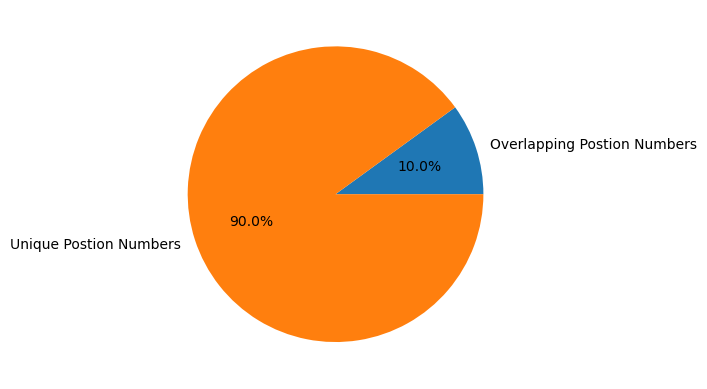

In [33]:
import matplotlib.pyplot as plt
common_position_numbers = set(applicant_df["Position Number"]).intersection(set(employee_df["Position Number"]))

# Create a subset of the employee data that includes only these Position Numbers
employee_subset_df = employee_df[employee_df["Position Number"].isin(common_position_numbers)]

# Define the output file path
employee_subset_file_path = "Redacted_Employee_Data_Subset.csv"

# Save the employee subset to a CSV file
employee_subset_df.to_csv(employee_subset_file_path, index=False)
overlap_count = (len(common_position_numbers))
employee_count = len(employee_df)-(len(common_position_numbers))

labels = 'Overlapping Postion Numbers', 'Unique Postion Numbers'
sizes = [overlap_count, employee_count]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')

In [24]:
significant_differences = []
job_families = employee_subset_df["Job Family"].dropna().unique()
demographic_columns = ["Sex", "Disabled", "Disab Vet", "Race/Ethnicity", "Mil Status"]

# Iterate over all job families and demographic columns
for job_family in job_families:
    for demographic in demographic_columns:
        # Filter employee and applicant data for the current job family
        employee_subset =employee_subset_df[employee_df["Job Family"] == job_family]
        applicant_subset = applicant_df[applicant_df["Job Family"] == job_family]

        # Calculate percentage distributions
        employee_counts = employee_subset[demographic].value_counts(normalize=True) * 100
        applicant_counts = applicant_subset[demographic].value_counts(normalize=True) * 100

        # Calculate raw counts
        employee_raw_counts = employee_subset[demographic].value_counts()
        applicant_raw_counts = applicant_subset[demographic].value_counts()

        # Align the indices for comparison (fill missing categories with 0%)
        combined_categories = employee_counts.index.union(applicant_counts.index)
        employee_counts = employee_counts.reindex(combined_categories, fill_value=0)
        applicant_counts = applicant_counts.reindex(combined_categories, fill_value=0)
        employee_raw_counts = employee_raw_counts.reindex(combined_categories, fill_value=0)
        applicant_raw_counts = applicant_raw_counts.reindex(combined_categories, fill_value=0)

        # Calculate differences
        differences = employee_counts - applicant_counts

        # Store significant differences if absolute value exceeds 7.5%
        significant = differences[abs(differences) > 7.5]

        if not significant.empty:
            for category in significant.index:
                significant_differences.append({
                    "Job Family": job_family,
                    "Demographic": demographic,
                    "Category": category,
                    "Employee Percentage (%)": round(employee_counts[category], 2),
                    "Applicant Percentage (%)": round(applicant_counts[category], 2),
                    "Difference (%)": round(differences[category], 2),  # Positive or negative
                    "Employee Count": int(employee_raw_counts[category]),
                    "Applicant Count": int(applicant_raw_counts[category])
                })

# Display significant differences
if significant_differences:
    significant_df = pd.DataFrame(significant_differences)
    significant_df = significant_df.sort_values(by=["Job Family", "Demographic", "Difference (%)"], ascending=[True, True, False])
    
    # Pretty display with pandas styling
    styled_df = significant_df.style.format({
        "Employee Percentage (%)": "{:.2f}",
        "Applicant Percentage (%)": "{:.2f}",
        "Difference (%)": "{:.2f}"
    }).set_table_styles([
        {"selector": "th", "props": [("font-weight", "bold"), ("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ]).set_caption("Significant Differences in Demographics by Job Family")
    
    # Show the styled table
    display(styled_df)
else:
    print("No significant differences found.")

significant_df.to_csv("Significant Differences in Demographics by Job Family Subset.csv", index=False)

C:\Users\Feeder2\AppData\Local\Temp\ipykernel_46720\558714831.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  employee_subset =employee_subset_df[employee_df["Job Family"] == job_family]
C:\Users\Feeder2\AppData\Local\Temp\ipykernel_46720\558714831.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  employee_subset =employee_subset_df[employee_df["Job Family"] == job_family]
C:\Users\Feeder2\AppData\Local\Temp\ipykernel_46720\558714831.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  employee_subset =employee_subset_df[employee_df["Job Family"] == job_family]
C:\Users\Feeder2\AppData\Local\Temp\ipykernel_46720\558714831.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  employee_subset =employee_subset_df[employee_df["Job Family"] == job_family]
C:\Users\Feeder2\AppData\Local\Temp\ipykernel_46720\558714831.py:9: UserWarning: Boolean Series key will be 

,Job Family,Demographic,Category,Employee Percentage (%),Applicant Percentage (%),Difference (%),Employee Count,Applicant Count
8,Accounting & Finance,Disabled,Y,42.86,28.70,14.16,6,66
7,Accounting & Finance,Disabled,N,57.14,71.30,-14.16,8,164
9,Accounting & Finance,Mil Status,Not a Protected Veteran,10.00,1.49,8.51,3,6
5,Accounting & Finance,Sex,Female,66.67,54.34,12.32,20,219
6,Accounting & Finance,Sex,Male,30.00,44.91,-14.91,9,181
27,Athletics,Disabled,Y,50.00,29.49,20.51,3,23
26,Athletics,Disabled,N,50.00,70.51,-20.51,3,55
30,Athletics,Mil Status,Not a Veteran,62.50,51.54,10.96,5,67
31,Athletics,Mil Status,Not indicated,37.50,45.38,-7.88,3,59
28,Athletics,Race/Ethnicity,Black/African American,37.50,9.23,28.27,3,12
